# Worst-case OMP tests

In [1]:
import numpy as np
import scipy as sp
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import sys
sys.path.append("../../")
import pyApproxTools as pat
importlib.reload(pat)

%matplotlib inline

### Worst-case OMP algorithm

We construct a measurement basis $W_m$ based on a given approximation basis $V_n$. Our ambient space $V$ is $H_0^1([0,1])$. Here $V_n$ is the sinusoids, normalised in $H_0^1([0,1])$, so $V_n = \mathrm{span}\{\phi_1,\ldots,\phi_n\}$, where $\phi_k = \frac{\sqrt{2}}{\pi k} \sin(k \pi x)$.

The measurements are assumed to be point evaluations, which have representer in $H_0^1$ of
$$
\omega_{x_0}(x) = \frac{1}{\sqrt{x_0 (1-x_0)}}
\begin{cases}
x (1 - x_0) & \text{for } x \le x_0 \\
(1 - x) x_0 & \text{for } x > x_0
\end{cases}
$$

This implementation of the algorithm finds the vector $v\in V_n$ that is furthest possible from $W_m$, that is at each step we look for 
$$
v_k = argmax_{v\in V_n,\, \|v\|=1} \| v - P_{W_{k-1}} v \|
$$
and then find the dictionary element most closely aligned with this vector
$$
\omega_k 
= \mathrm{argmax}_{\omega\in\mathcal{D}} |\left\langle \omega, v_k - P_{W_{k-1}} v_k \right\rangle| 
$$
It is because of the selection of $v_k$ that we call this the _worst-case_ approach. We find $v_k$ through the SVD decomposition of the cross-gramian of $W_{k-1}$ and $V_n$. Although this is expensive, it works out quite well as the slowest part of the algorithm is actually the dot product search through $\mathcal{D}$, as the SVD code is written in 

### Lets look at $\beta(V_n, W_m)$ for our worst-case OMP basis and a random basis for comparison
Note that this calculation is done for a small dictionary that only has $N=10^3$ elements, to save time, however as we saw in the collective-OMP, the size of the dictionary doesn't have a huge impact in this example.

In [2]:
N = 1e3
dictionary = pat.make_unif_dictionary(N)

ns = [20,40]
np.random.seed(3)
#n = 20
m = 200
bs_comp = np.zeros((len(ns), m))
bs_wcomp = np.zeros((len(ns), m))
bs_rand = np.zeros((len(ns), m))

Vn = pat.make_sin_basis(ns[-1])
Wms_comp = []
Wms_wcomp = []
Wms_rand = []

for j, n in enumerate(ns):

    gbc = pat.CollectiveOMP(m, dictionary, Vn.subspace(slice(0,n)), verbose=True)
    Wm_comp = gbc.construct_basis()
    Wms_comp.append(Wm_comp)
    Wm_comp_o = Wm_comp.orthonormalise()
    
    wcgbc = pat.WorstCaseOMP(m, dictionary, Vn.subspace(slice(0,n)), verbose=True)
    Wm_wcomp = wcgbc.construct_basis()
    Wms_wcomp.append(Wm_wcomp)
    Wm_wcomp_o = Wm_wcomp.orthonormalise()

    Wm_rand = pat.make_random_delta_basis(m)
    Wms_rand.append(Wm_rand)
    Wm_rand_o = Wm_rand.orthonormalise()

    BP_comp_l = pat.BasisPair(Wm_comp_o, Vn.subspace(slice(0,n)))
    BP_wcomp_l = pat.BasisPair(Wm_wcomp_o, Vn.subspace(slice(0,n)))    
    BP_rand_l = pat.BasisPair(Wm_rand_o, Vn.subspace(slice(0,n)))
    for i in range(n, m):
        BP_comp = BP_comp_l.subspace(Wm_indices=slice(0,i))
        bs_comp[j, i] = BP_comp.beta()

        BP_wcomp =  BP_wcomp_l.subspace(Wm_indices=slice(0,i))
        bs_wcomp[j, i] = BP_wcomp.beta()
        
        BP_rand = BP_rand_l.subspace(Wm_indices=slice(0,i))
        bs_rand[j, i] = BP_rand.beta()



Generating basis from greedy algorithm with dictionary: 
i 	 || P_Vn (w - P_Wm w) ||
1 : 	 0.8571343821013427
2 : 	 0.8478519661242145
3 : 	 0.5929925737817036
4 : 	 0.5199125278326096
5 : 	 0.48416159219343224
6 : 	 0.3199274022393138
7 : 	 0.29852256538188515
8 : 	 0.2631264247642689
9 : 	 0.26203418166487313
10 : 	 0.14756995955527205
11 : 	 0.138525047449238
12 : 	 0.12731472282743977
13 : 	 0.12308941055655266
14 : 	 0.10431733420279936
15 : 	 0.0876053294817264
16 : 	 0.07296362498788489
17 : 	 0.057201325874279674
18 : 	 0.04963931221244647
19 : 	 0.045649954350597016
20 : 	 0.03924205166611706
21 : 	 0.034793938435448646
22 : 	 0.03430621290109176
23 : 	 0.032058761270105124
24 : 	 0.030850765953742542
25 : 	 0.028143467877218664
26 : 	 0.025898318452608142
27 : 	 0.023928063825036858
28 : 	 0.012521433198424449
29 : 	 0.012498860576901354
30 : 	 0.012082336378661114
31 : 	 0.009100673844698114
32 : 	 0.00864433564253438
33 : 	 0.007805843669642069
34 : 	 0.006387809525690213

81 : 	 0.008136165987420951
82 : 	 0.008087451055128508
83 : 	 0.008109120274763737
84 : 	 0.008282685431791337
85 : 	 0.006691795279399303
86 : 	 0.0064383779762116206
87 : 	 0.009644245485896125
88 : 	 0.00756431742065547
89 : 	 0.007090458504124902
90 : 	 0.008642606907525954
91 : 	 0.006106265866731547
92 : 	 0.006499483476647368
93 : 	 0.007516622169707429
94 : 	 0.005643232968812903
95 : 	 0.006209006582511112
96 : 	 0.005840197491788643
97 : 	 0.005926002901272209
98 : 	 0.006075354749426734
99 : 	 0.005064753645566494
100 : 	 0.004977638562115513
101 : 	 0.005034523321118034
102 : 	 0.004767705272882963
103 : 	 0.004476869914611131
104 : 	 0.005082875054927882
105 : 	 0.004895029290965663
106 : 	 0.004435295335589895
107 : 	 0.004730571737457459
108 : 	 0.004790455354853729
109 : 	 0.005060423472025372
110 : 	 0.004753831010693849
111 : 	 0.004059391385084168
112 : 	 0.004682752626126246
113 : 	 0.004908607919785216
114 : 	 0.005500394996608524
115 : 	 0.004620317424671151
116 

163 : 	 0.00014279706025199839
164 : 	 0.00014142493122992726
165 : 	 0.0001382922743076586
166 : 	 0.0001376135958188997
167 : 	 0.00013522360512408353
168 : 	 0.00013515266231572834
169 : 	 0.00013438965733462928
170 : 	 0.00013250819752082108
171 : 	 0.00012815152576600944
172 : 	 0.0001278683845837402
173 : 	 0.00012330783852770337
174 : 	 0.00012244969322402325
175 : 	 0.00011941448124054751
176 : 	 0.00011469600822495075
177 : 	 0.00010848462056326554
178 : 	 0.0001077314300058867
179 : 	 0.00010767002776077273
180 : 	 0.00010740617879160421
181 : 	 0.00010607780021899677
182 : 	 0.00010581076892779904
183 : 	 0.00010454096968166584
184 : 	 0.00010438662171273339
185 : 	 0.00010359719200953031
186 : 	 0.0001003106371937067
187 : 	 9.733111557838572e-05
188 : 	 9.403433487869499e-05
189 : 	 9.190735581066428e-05
190 : 	 9.101585386403642e-05
191 : 	 9.066868158448276e-05
192 : 	 8.759709749225725e-05
193 : 	 8.647089854316739e-05
194 : 	 8.536972630582111e-05
195 : 	 8.36820291887

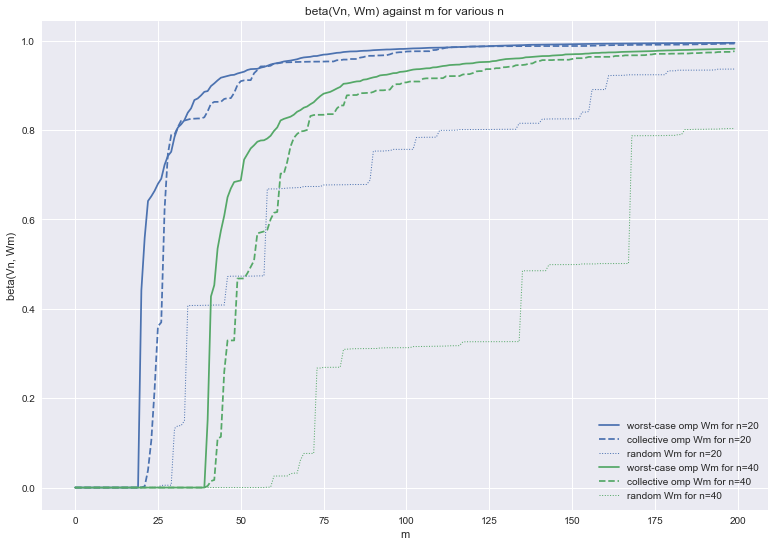

In [3]:
sns.set_palette("deep")
cp = sns.color_palette()

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title='beta(Vn, Wm) against m for various n')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')

for i, n in enumerate(ns):
    plt.plot(range(m), bs_wcomp[i, :], label='worst-case omp Wm for n={0}'.format(n), color=cp[i])#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))    
    plt.plot(range(m), bs_comp[i, :], '--', label='collective omp Wm for n={0}'.format(n), color=cp[i])#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))
    plt.plot(range(m), bs_rand[i, :], ':', label='random Wm for n={0}'.format(n), color=cp[i], lw=1)#r'Random $W_m$, $n={{{0}}}$'.format(n))

ax.set(xlabel='m', ylabel='beta(Vn, Wm)')#r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=4)
plt.show()

In [4]:
bs_unif_int = np.zeros((len(ns), m))
Vn = pat.make_sin_basis(ns[-1])

Wms_unif_int = []

for j, n in enumerate(ns):
    for i in range(n, m):
        Wm_unif_int = pat.Basis([pat.FuncVector(params=[[x]],coeffs=[[1.0]],funcs=['H1UIDelta']) for x in np.linspace(0.0, 1.0, i, endpoint=False)+0.5/i])
        Wm_unif_int_o = Wm_unif_int.orthonormalise()

        BP_ui = pat.BasisPair(Wm_unif_int_o, Vn.subspace(slice(0,n)))
        bs_unif_int[j, i] = BP_ui.beta()

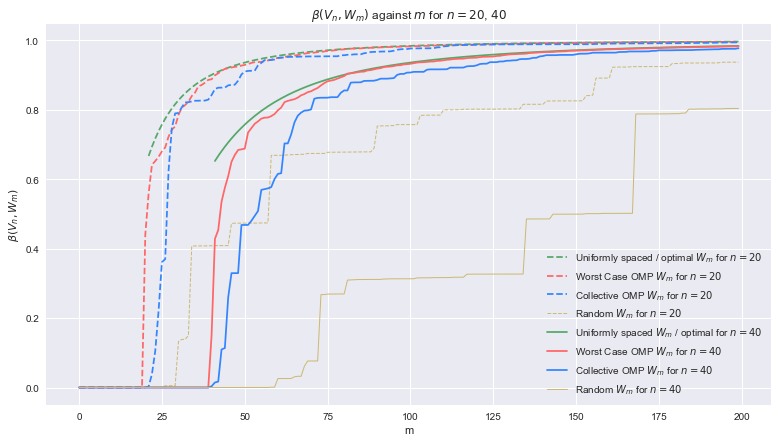

In [5]:
sns.set_palette("deep")
cp = sns.color_palette()

bl = (51/255, 133/255, 255/255)
re = (255/255, 102/255, 102/255)

axs = []
fig = plt.figure(figsize=(13, 7))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n=20$, $40$')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')

#for i, n in enumerate(ns):
i=0
n=ns[i]
plt.plot(range(n+1,m), bs_unif_int[i, n+1:], '--', label=r'Uniformly spaced / optimal $W_m$ for $n={{{0}}}$'.format(n), color=cp[1])
plt.plot(range(m), bs_wcomp[i, :], '--', label=r'Worst Case OMP $W_m$ for $n={{{0}}}$'.format(n), color=re)#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))    
plt.plot(range(m), bs_comp[i, :], '--', label=r'Collective OMP $W_m$ for $n={{{0}}}$'.format(n), color=bl)#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))
plt.plot(range(m), bs_rand[i, :], '--', label=r'Random $W_m$ for $n={{{0}}}$'.format(n), color=cp[4], lw=1)#r'Random $W_m$, $n={{{0}}}$'.format(n))
i=1
n=ns[i]
plt.plot(range(n+1,m), bs_unif_int[i, n+1:], label=r'Uniformly spaced $W_m$ / optimal for $n={{{0}}}$'.format(n), color=cp[1])
plt.plot(range(m), bs_wcomp[i, :], label=r'Worst Case OMP $W_m$ for $n={{{0}}}$'.format(n), color=re)#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))    
plt.plot(range(m), bs_comp[i, :], label=r'Collective OMP $W_m$ for $n={{{0}}}$'.format(n), color=bl)#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))
plt.plot(range(m), bs_rand[i, :], label=r'Random $W_m$ for $n={{{0}}}$'.format(n), color=cp[4], lw=1)#r'Random $W_m$, $n={{{0}}}$'.format(n))

ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$')#r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=4)
plt.savefig('WCOMPvsCOMPvsUnif.pdf')
plt.show()

In [20]:
cp[0]


(0.29803921568627451, 0.44705882352941179, 0.69019607843137254)